In [1]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt

from torch import nn
from keras.datasets import mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()
x = (x_train[0]  > 1).astype(np.float64)

/usr/local/lib/python2.7/dist-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
from IPython.core.pylabtools import figsize
figsize(20, 7)

# Sample Input
Inputs to the models are spikes (i.e. binary $\{0, 1\}$)

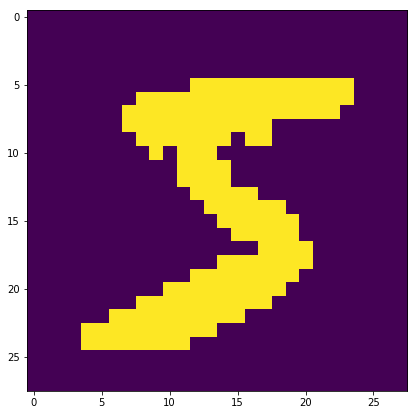

In [3]:
plt.imshow(x); plt.show()

In [4]:
def _generate_mask(row, col, n, r=3):
    y,x = np.ogrid[-row:n-row, -col:n-col]
    mask = x*x + y*y <= r*r

    array = np.zeros((n, n))
    array[mask] = 1
    return array

def _build_layer_connections(output_shape, input_shape):
    # no weights for connections; only used for top layer
    if input_shape is None: return None

    connections = np.zeros(output_shape + input_shape)
    scale_row = input_shape[0] / float(output_shape[0])
    scale_col = input_shape[1] / float(output_shape[1])
    
    for row in range(output_shape[0]):
        for col in range(output_shape[1]):
            connections[row][col] = _generate_mask(int(scale_row*row), int(scale_col*col), input_shape[0])
    return torch.from_numpy(connections)

# Building Weights and Connections

In [5]:
input_shape = (28,28); output_shape = (10,10)

weights = 0.1 * torch.randn(output_shape+input_shape, dtype=torch.float64)
connections = _build_layer_connections(output_shape, input_shape)

The weights and connections are of shape: $(H_o, W_o, H_i, W_i)$  
$H_o$ is the height of the output  
$W_o$ is the width of the output  
$H_i$ is the height of the input  
$W_i$ is the width of the input   

So in this case a $28 x 28$ input image is fed to a layer with $10 x 10$ neurons

In [6]:
weights.shape, connections.shape

(torch.Size([10, 10, 28, 28]), torch.Size([10, 10, 28, 28]))

# Connections
Each neuron has a local receptive field to the input below.  
Unlike fully connected networks where every neuron connects to all other neurons.  
And convolutional networks where the same weights are shared across the whole input space. 

<img src="http://i-systems.github.io/HSE545/machine%20learning%20all/Workshop/180208_COSEIK/image_files/cnn_locality.png" width=800>

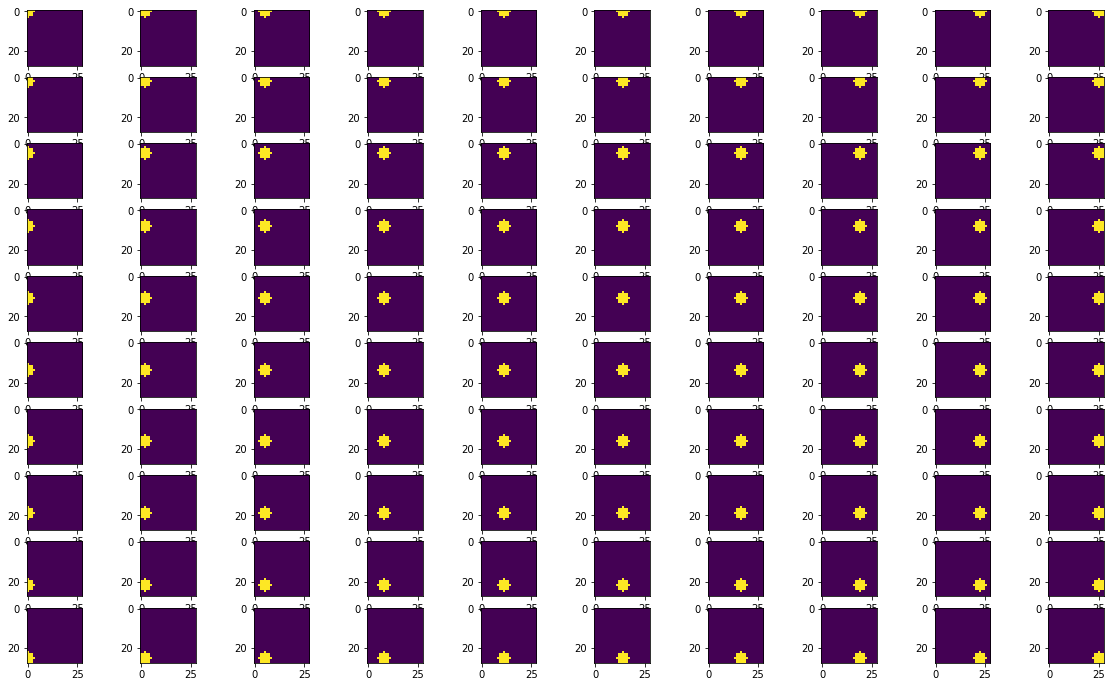

In [7]:
plt.figure(figsize=(20,12))
count = 1
for i in range(10):
    for j in range(10):
        plt.subplot(10,10,count)
        plt.imshow(connections[i,j]); 
        count += 1
plt.show()

# Connections x Input
The plot below shows what pieces of the input each neuron sees. Note that no neuron gets a complete view of the original $5$. They are restricted to local chunks. 

In [8]:
con = x * connections

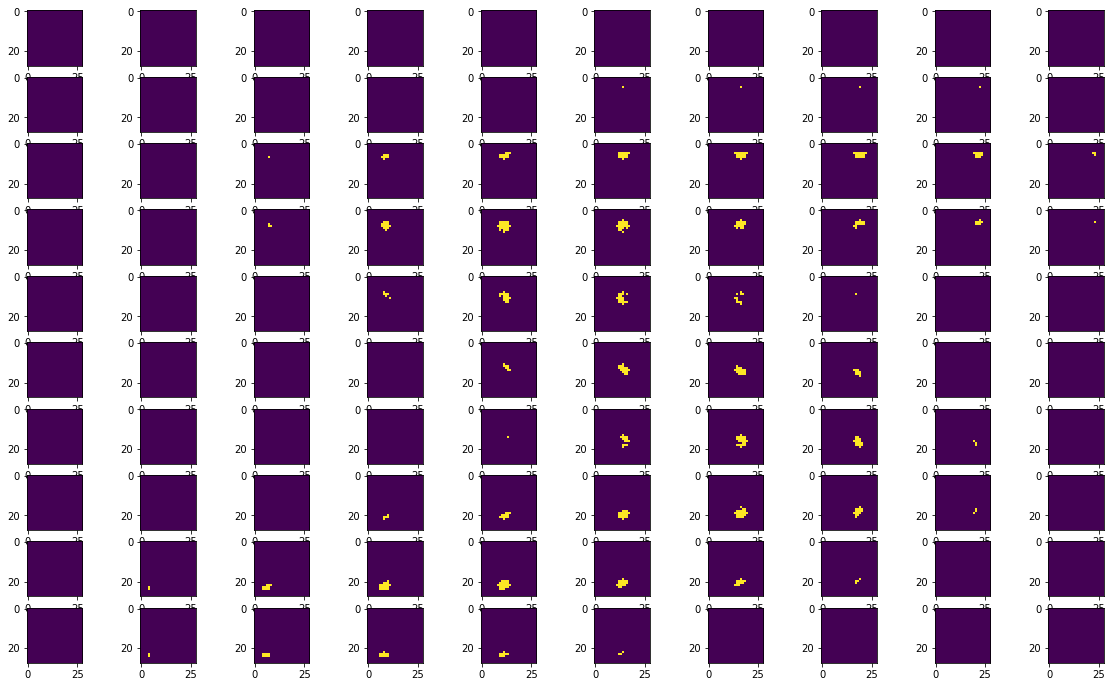

In [9]:
plt.figure(figsize=(20,12))
count = 1
for i in range(10):
    for j in range(10):
        plt.subplot(10,10,count)
        plt.imshow(con[i,j]); 
        count += 1
plt.show()

# Summed Output for Layer
Integrate all the neurons inputs from its dendrites. The scalar value can be thought of as a voltage potential of the neuron.

In [10]:
state = torch.einsum('rchw,rchw->rc', (con, weights))

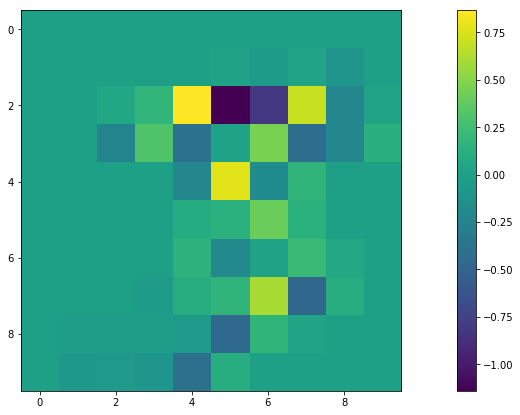

In [11]:
plt.imshow(state); plt.colorbar(); plt.show()

# Sparsity

$n$ is the number of neurons and $x$ is the number of active neurons  
If we enforce sparsity percentage, $p$ (i.e. $n*p$ neurons are active at a time)  
The number of possible patterns the neurons can represent is (the number of ways $n$ neurons can be aranged if $n*p$ are active):

\begin{equation}
    {n \choose x} = \frac{n!}{x!(n-x)!} 
\end{equation}

### Example
If we have 100 neurons in a layer ($n=100$), allowing $20%$ sparsity ($p=0.2$). The number of possible patterns we can represent is:

\begin{equation}
    {100 \choose 20} = \frac{100!}{20!(100-20)!} = 535983370403809682970 = 5.3598x10^{20}
\end{equation}

In [12]:
sparsity = 0.2; state = state[None,None]
pool = nn.MaxPool2d((2,2),return_indices=True); unpool = nn.MaxUnpool2d((2,2))

# pooling to get the most active neurons in an area; this enforces local inhibition and competition between neurons
max_values, indices = pool(state)
max_values = unpool(max_values, indices)

# get the k most active neurons in a layer; enforce global sparsity within the layer
flattened_state = state.view(-1)
top_k = torch.zeros(flattened_state.shape, dtype=torch.uint8)
_,indexes = torch.topk(flattened_state, int(flattened_state.shape[0]*.1))

# combine pool and top k to find active neurons within the layer
top_k[indexes] = 1; top_k = top_k.reshape(state.shape)
active_neurons = ((max_values == state) & ( max_values > .1) & top_k).squeeze() 

# Active Neurons

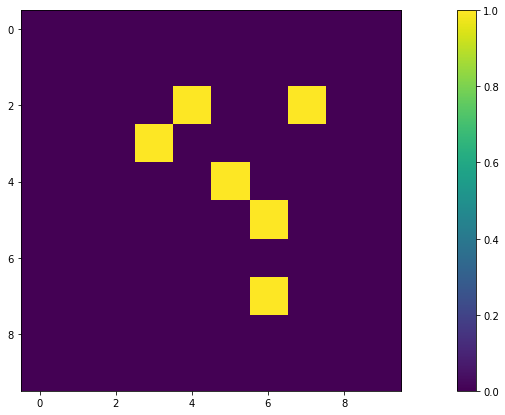

In [13]:
plt.imshow(active_neurons); plt.colorbar(); plt.show()

# Learning

Learning, updating synaptic weights, is done using a local hebbian rule. Where the synapse connecting neuron $i$ to neuron $j$ is modified according to the input, $I_i$, and output, $O_j$.

\begin{equation}
    \Delta w_{i,j} = \alpha I_i O_j
\end{equation}

<img src="https://cdn.kastatic.org/ka-perseus-images/b404bfc9d6246ff3475f6fd2b34fbb7374fc4873.png">

So if neuron $i$ fires ($I_i = 1$) and the postsynaptic cell $j$ fires ($O_j = 1$) the weight will be strengthened because this connection took part in making the post synaptic cell fire. 

In [14]:
#x = torch.from_numpy(x).type(torch.float64)
pre_post_prod = torch.einsum('rc,hw->rchw', (active_neurons.double(), torch.Tensor(x).double()))
pre_post_prod = pre_post_prod * connections

Only synapses who contributed to making their cell fire are rewarded with a synaptic update. 

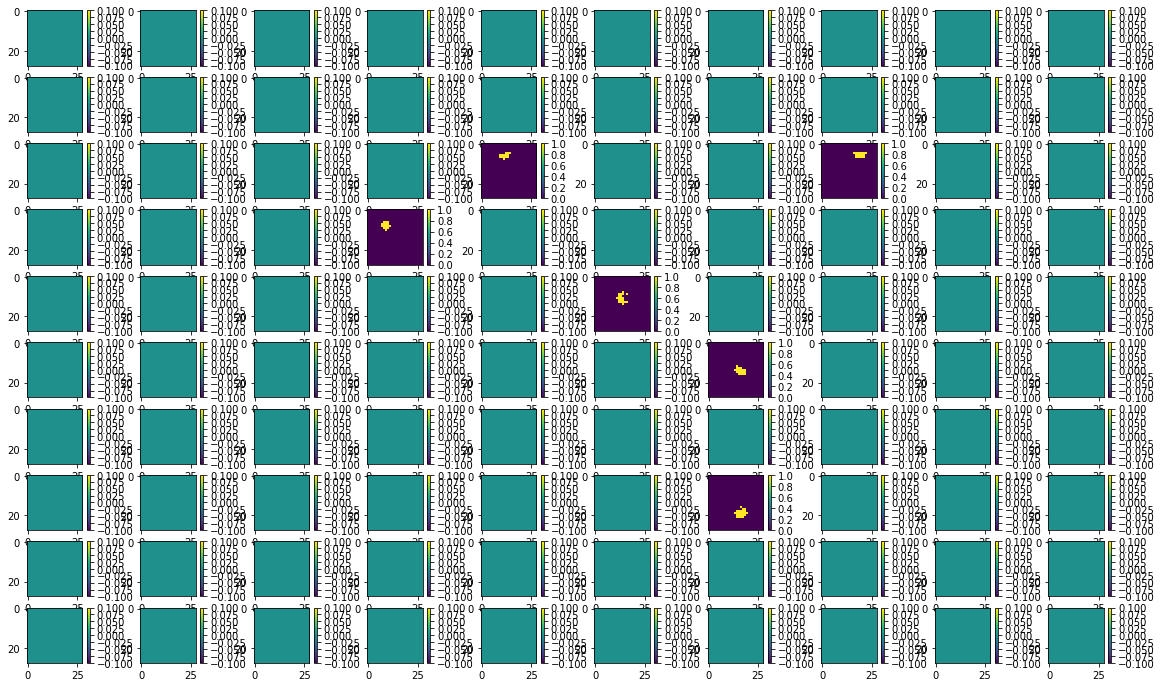

In [15]:
plt.figure(figsize=(20,12))
count = 1
for i in range(10):
    for j in range(10):
        plt.subplot(10,10,count)
        plt.imshow(pre_post_prod[i,j]); plt.colorbar()
        count += 1
plt.show()